# Word embedding using tf-idf matrices
This notebook explores using tf-idf matrices to create these company embeddings. 

Tf-Idf stands for _term frequency - inverse document frequency_. Each row in this matrix represents one document (in this case, one annaul report of a given company) and each column represents a word (or a sequence of words called an n-gram, like "University of Toronto"). 

A term frequency matrix has the count of occurences of a given word for each document, while a tf-idf matrix performs a transformation on that term frequency matrix. The computation for each cell is as follows:

<!-- \begin{align*}
\text{tf-idf}(t,d) &= \text{tf}(t,d) \cdot \text{idf}(t,d)\\ \\
\text{Where: } \quad \text{tf}(t,d) &= |t| \text{ in } d\\ \\
\text{idf}(t,d) &= \log\frac{N}{\text{df}(t)}\\
\end{align*} -->
![math](../images/tfidf_1.png)

- Where **t** is the current term we are process, and **d** is the current document we are looking in
- Where **N** is the total number of documents in the document set and **df(t)** is the document frequency of t;
    - The document frequency is the number of documents in the document set that contain the term t  
^ From [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)

**Why do we do this?**

The purpose of a tf-idf transformation is give more importance to words that occur less frequently among all the documents. Common terms among financial documents like these could contain "financial" or "business" but they don't provide any extra information to help us identify what makes a given company _unique_. tf-idf augments the term counts by giving higher weights to terms that are less common within the collection of documents but mentioned frequently in one document, implying these terms make this document special.

We'll be training two models from `sklearn`'s `feature_extraction`, first using a `CountVectorizer` to obtain term-frequencies of terms of size 2-4 (we do this as some terms such as "cloud computing" carry more meaning than those words do separately. We also only select the top 600 words by freqeuncy as the columns. 

The result is then piped into a `TfidfTransformer`, augmenting the values so the values more accurately represent the **importance** of a given term.

In [12]:
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, '..')
%load_ext autoreload
%autoreload 2
%aimport std_func

# Hide warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

df = pd.read_csv("../data/preprocessed.csv")
pipe = Pipeline([('count', CountVectorizer(ngram_range = (2,4),
                                           stop_words = 'english', max_features = 600)),
                  ('tfidf', TfidfTransformer())]).fit(df["coDescription_stopwords"])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Here are some of the terms we are left with after passing all our documents through the `CountVectorizer` and `TfidfTransformer`.

In [2]:
feature_names = pd.DataFrame(pipe['count'].get_feature_names_out())
feature_names.sample(5)

0
300         income tax purpose
297          including limited
366          medicinal product
256  following table set forth
321              issued patent

As you can see below, the matrix is quite sparse since some companies don't contain any occurrences of some terms.

In [3]:
# The tf-idf matrix
tfidf =  pd.DataFrame(pipe.transform(df["coDescription_stopwords"]).toarray())
tfidf.head()

0         1    2         3         4         5         6    7         8    \
0  0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
1  0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
2  0.0  0.000000  0.0  0.000000  0.030074  0.000000  0.068363  0.0  0.000000   
3  0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.059925  0.0  0.000000   
4  0.0  0.037094  0.0  0.002481  0.006809  0.010094  0.001935  0.0  0.010972   

        9    ...  590  591       592       593  594  595       596       597  \
0  0.000000  ...  0.0  0.0  0.000000  0.000000  0.0  0.0  0.142196  0.159010   
1  0.000000  ...  0.0  0.0  0.000000  0.000000  0.0  0.0  0.000000  0.000000   
2  0.000000  ...  0.0  0.0  0.000000  0.000000  0.0  0.0  0.000000  0.000000   
3  0.000000  ...  0.0  0.0  0.000000  0.000000  0.0  0.0  0.070304  0.047170   
4  0.009869  ...  0.0  0.0  0.050738  0.010656  0.0  0.0  0.000000  0.155342   

   598       599  
0  0.0  0.000000  
1  0.0  0.000000  
2  0.0  0.000000  
3  0.0  0.000000  
4  0.0  0.011082  

[5 rows x 600 columns]

This is a 2D PCA reduction of that 600 dimensional space. We're plotting the first two dimensions, which capture the most variance.

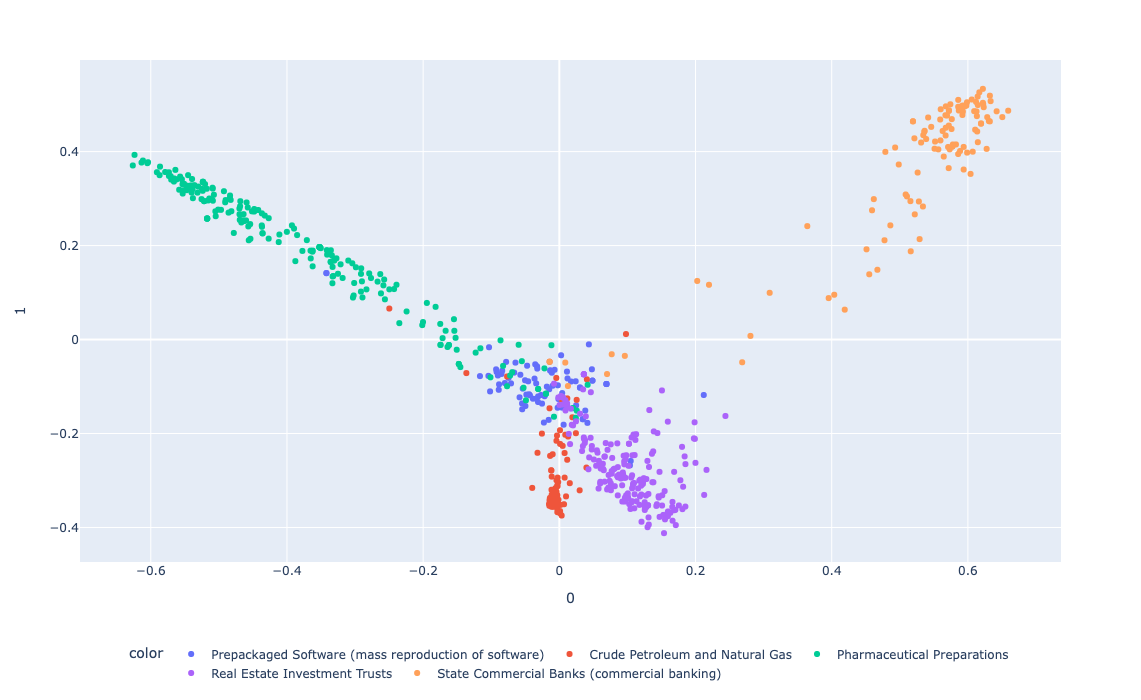

In [4]:
plot = std_func.pca_visualize_2d(tfidf, df.loc[:,["name","SIC_desc"]])

And this is a 3-dimensional plot which plots the first three dimensions. You can interact with it as well.

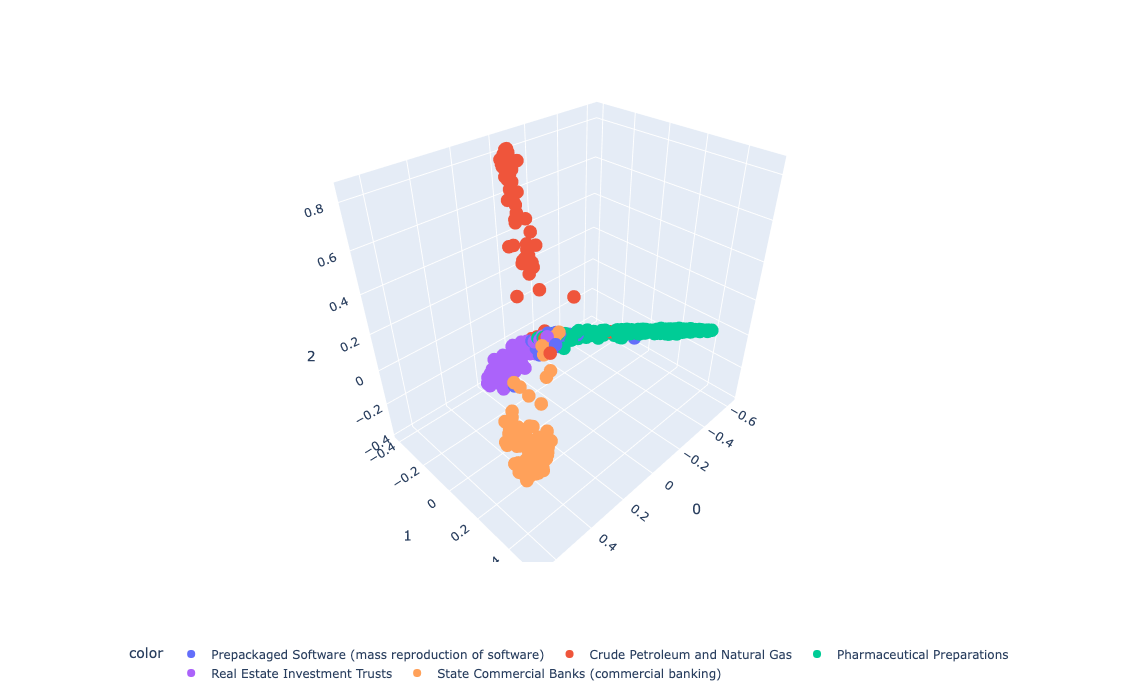

In [5]:
std_func.pca_visualize_3d(plot)

We can see from the above PCA plot of the first three dimensions that there are clearly terms which certain industries are more drawn toward. Unfortunately, the Real Estate and Software industries still seem quite closely clustered.

We can look at the explained variance of each dimension the PCA embedding of our tf-idf matrix produced below:

In [6]:
# From the explained variance ratio, we see that the top three dimensions don't actually explain that much of the variation that exists within our data/companies.
plot[0].explained_variance_ratio_

array([0.1203797 , 0.09021696, 0.06845749, 0.03556207, 0.01948634,
       0.01886287, 0.01731975, 0.016957  , 0.01687483, 0.01577069])

And the total variance explained by the top three dimensions:

In [7]:
plot[0].explained_variance_ratio_[0:3].sum()

0.27905414951961494

Based on the above, the top three principle components only explain 27.9% of the total variance that exists within the data.

If you'd like to analyze how much a given term contributes to each of the 10 dimensions, please see the DataFrame hidden below:

In [8]:
components = pd.DataFrame(plot[0].components_, columns = feature_names)
components.reindex(components.abs().sort_values(0, axis = 1).index)
# components[0:2]

(ability make,)  (accounting standard,)  (acquire property,)  (act act,)  \
0         0.008464                0.003215             0.009458    0.014314   
1        -0.006914               -0.001608            -0.033876    0.014038   
2        -0.008100               -0.000819            -0.033001    0.001018   
3        -0.010786                0.013262            -0.047522    0.002819   
4        -0.006156                0.006349            -0.025236   -0.006557   
5         0.002625                0.030151             0.007055    0.003666   
6         0.005510               -0.023275            -0.020049    0.000175   
7         0.000903               -0.005742            -0.036827   -0.005527   
8         0.006878               -0.005550            -0.008769    0.003211   
9        -0.011309               -0.008520             0.043345   -0.004144   

   (act amended,)  (additional capital,)  (additional information,)  \
0        0.009306               0.006414                  -0.009847   
1        0.002999              -0.001260                  -0.000087   
2       -0.007243              -0.001871                  -0.012349   
3        0.018005               0.001505                   0.016095   
4       -0.012356               0.001267                  -0.030696   
5       -0.009032               0.014341                   0.007402   
6        0.000409              -0.002443                   0.016658   
7       -0.003031              -0.006324                  -0.001028   
8        0.015181               0.002436                   0.012087   
9        0.011069              -0.010188                  -0.024274   

   (adequately capitalized,)  (adverse effect,)  (adverse effect business,)  \
0                   0.022502          -0.003787                   -0.000597   
1                   0.021544          -0.018656                   -0.008920   
2                   0.002899           0.004780                   -0.003369   
3                  -0.001664          -0.003365                    0.003747   
4                  -0.003145          -0.039234                   -0.024999   
5                  -0.001743           0.016671                    0.005784   
6                  -0.000822           0.038118                    0.012490   
7                   0.000424          -0.024870                   -0.017395   
8                   0.001410           0.053482                    0.020355   
9                  -0.000989          -0.042209                   -0.022528   

   ...  (vice president,)  (volcker rule,)  (wa million,)  \
0  ...           0.003886         0.023861       0.006737   
1  ...          -0.007964         0.024241      -0.004846   
2  ...          -0.012004         0.004508      -0.008028   
3  ...           0.084738        -0.000753       0.013445   
4  ...          -0.010285        -0.002410      -0.014140   
5  ...          -0.101104        -0.001570       0.002636   
6  ...          -0.046821         0.003653      -0.023540   
7  ...           0.010411        -0.012293       0.018140   
8  ...          -0.090148        -0.002929      -0.003663   
9  ...           0.104639        -0.004243      -0.010418   

   (weighted average,)  (wholly owned,)  (wholly owned subsidiary,)  \
0             0.011844         0.001967                    0.001536   
1            -0.017862        -0.005544                   -0.003738   
2            -0.019714        -0.010987                   -0.007323   
3            -0.022549         0.004597                    0.006835   
4            -0.002859        -0.017023                   -0.014703   
5             0.006705         0.015223                    0.014753   
6            -0.007093        -0.007102                   -0.010678   
7             0.006404        -0.019163                   -0.016224   
8            -0.015036        -0.005960                   -0.005595   
9            -0.027804         0.010877                    0.016097   

   (wide range,)  (year end

And finally, this DataFrame is sorted by the amount each term contributes to the **first** dimension, which captures the most variance in our data. This tells us that the largest variations/spread of companies along the x axis in the 2D PCA plot measures how much a company has to with with Oil & Gas, or real estate.

In [9]:
components.abs().sort_values(2, axis = 1, ascending = False)

(natural gas,)  (oil natural,)  (oil natural gas,)  (real estate,)  \
0        0.002005        0.001982            0.001937        0.188639   
1        0.196597        0.125686            0.123456        0.214145   
2        0.562633        0.361787            0.355658        0.322306   
3        0.155039        0.106771            0.105380        0.409967   
4        0.175931        0.131868            0.130252        0.307356   
5        0.095358        0.076463            0.076678        0.156000   
6        0.110229        0.112606            0.111171        0.087428   
7        0.017938        0.024323            0.025921        0.125678   
8        0.073424        0.102257            0.102134        0.104251   
9        0.051478        0.071463            0.073579        0.178675   

   (oil gas,)  (hydraulic fracturing,)  (operating partnership,)  \
0    0.000110                 0.000673                  0.026153   
1    0.099522                 0.045112                  0.115532   
2    0.242208                 0.126237                  0.102704   
3    0.010175                 0.028907                  0.103400   
4    0.136623                 0.013909                  0.047753   
5    0.179768                 0.003712                  0.081003   
6    0.316628                 0.037741                  0.164216   
7    0.202736                 0.018873                  0.239512   
8    0.457472                 0.060820                  0.116409   
9    0.390574                 0.034744                  0.135743   

   (proved reserve,)  (square foot,)  (joint venture,)  ...  (asset le,)  \
0           0.000259        0.018317          0.017743  ...     0.021999   
1           0.034217        0.092581          0.092607  ...     0.018273   
2           0.094673        0.090834          0.087948  ...     0.000407   
3           0.022930        0.058631          0.082267  ...     0.005541   
4           0.015358        0.006224          0.026471  ...     0.003958   
5           0.000027        0.175239          0.032719  ...     0.002966   
6           0.003455        0.174623          0.026388  ...     0.002398   
7           0.002502        0.162010          0.142235  ...     0.010661   
8           0.012561        0.157998          0.048439  ...     0.005124   
9           0.007602        0.143087          0.008688  ...     0.003371   

   (condition result operation,)  (operation financial,)  (prior approval,)  \
0                       0.011730                0.002284           0.014785   
1                       0.016138                0.006959           0.015385   
2                       0.000367                0.000360           0.000193   
3                       0.004570                0.004581           0.001488   
4                       0.007583                0.018923           0.009668   
5                       0.025272                0.006799           0.007912   
6                       0.035772                0.000011           0.000944   
7                       0.015704                0.003997           0.011126   
8                       0.075244                0.015052           0.001656   
9                       0.046057                0.018470           0.002650   

   (result operation,)  (deferred tax asset,)  \
0             0.012128               0.010725   
1             0.029917               0.003795   
2             0.000186               0.000185   
3             0.006425               0.007491   
4             0.019914               0.023815   
5             0.044256               0.055783   
6             0.030662               0.031891   
7             0.001043               0.000579   
8             0.079382               0.018561   
9             0.068274               0.037931   

   (financial condition result operation,)  (federal state law,)  \
0                                 0.011656              0.009905   
1                                 0.016080              0.011678   

##  Performance Evaluation 

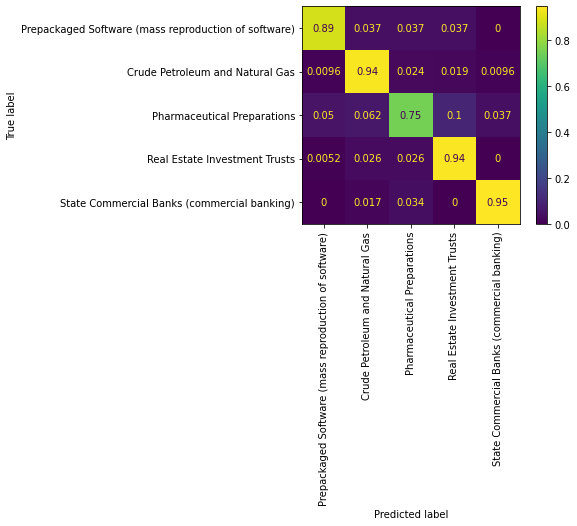

In [10]:
conf_mat = std_func.conf_mat(tfidf,df)

In [11]:
dot_product_df, accuracy, cm = std_func.dot_product(tfidf,df)
from sklearn.metrics import classification_report
print(classification_report(dot_product_df["y_true"], dot_product_df["y_pred"], target_names=df["SIC_desc"].unique()))

                                                      precision    recall  f1-score   support

Prepackaged Software (mass reproduction of software)       0.91      0.89      0.90        80
                     Crude Petroleum and Natural Gas       0.93      0.94      0.93       208
                         Pharmaceutical Preparations       0.78      0.75      0.76        80
                       Real Estate Investment Trusts       0.92      0.94      0.93       191
         State Commercial Banks (commercial banking)       0.96      0.95      0.95       116

                                            accuracy                           0.91       675
                                           macro avg       0.90      0.89      0.90       675
                                        weighted avg       0.91      0.91      0.91       675



From the confusion matrix and the classification report, we can conclude that the tf-idf company embedding does a good job overall at classifying the category of the companies, except for the Pharmaceutical industry. More specifically, this model is best at classifying companies in the Commerical Banking industry.